## Pareto-Front Vereinfachtes Modell

Dies ist eine vereinfachte Darstellung zur Erklrärung der Möglichkeiten einer Optimierung von Energiesystemen. Ziel ist es eine Darstellung zu schaffen, in der die Variablen Hausanschlüsse, Quellentemperatur, Leitungslänge in einer Pareto-Front gezeigt werden.

Dazu müssen die Quelle und eine linearisierte Wärmepumpe, die Leitung, und die Abnehmer als eine Vielzahl von identischen Einfamilienhäusern definiert werden. Die Zielfunktion ist die Minimierung des Wärmemischpreises. In der Darstellung sollen unterschiedliche Niveaus veranschaulicht werden, wodurch man den Vergleich zu dem Wärmemischpreis Gas & LW-WP sieht.

In [16]:
from gurobipy import *
from pyomo.environ import *
import numpy as np
import matplotlib.pyplot as plt

model = ConcreteModel()

In [17]:
# Aufrufen der anderen Programme

%run Modellparameter.ipynb

Definition von Indizes
Randbedingungen der Parameter

### Quelle

#### Technisch

In [18]:
# Temperatur wird weiter oben parametrisiert; die Wärmeleistung kann sie nach Bedarf zur Verfügung stellen

model.Quelle_H_Aus = Var(model.n, domain=NonNegativeReals) #[kW] # Ohne Wärmepumpe
'Erstmal nur Modell mit Wärmepumpe'
model.Quelle_H_Aus_WP = Var(model.n, domain=NonNegativeReals) #[kW] # Mit Wärmepumpe
model.Quelle_m_Aus = Var(model.n, domain=NonNegativeReals) #[kg/s] # Massenstrom aus der Quelle

###  Wärmepumpe

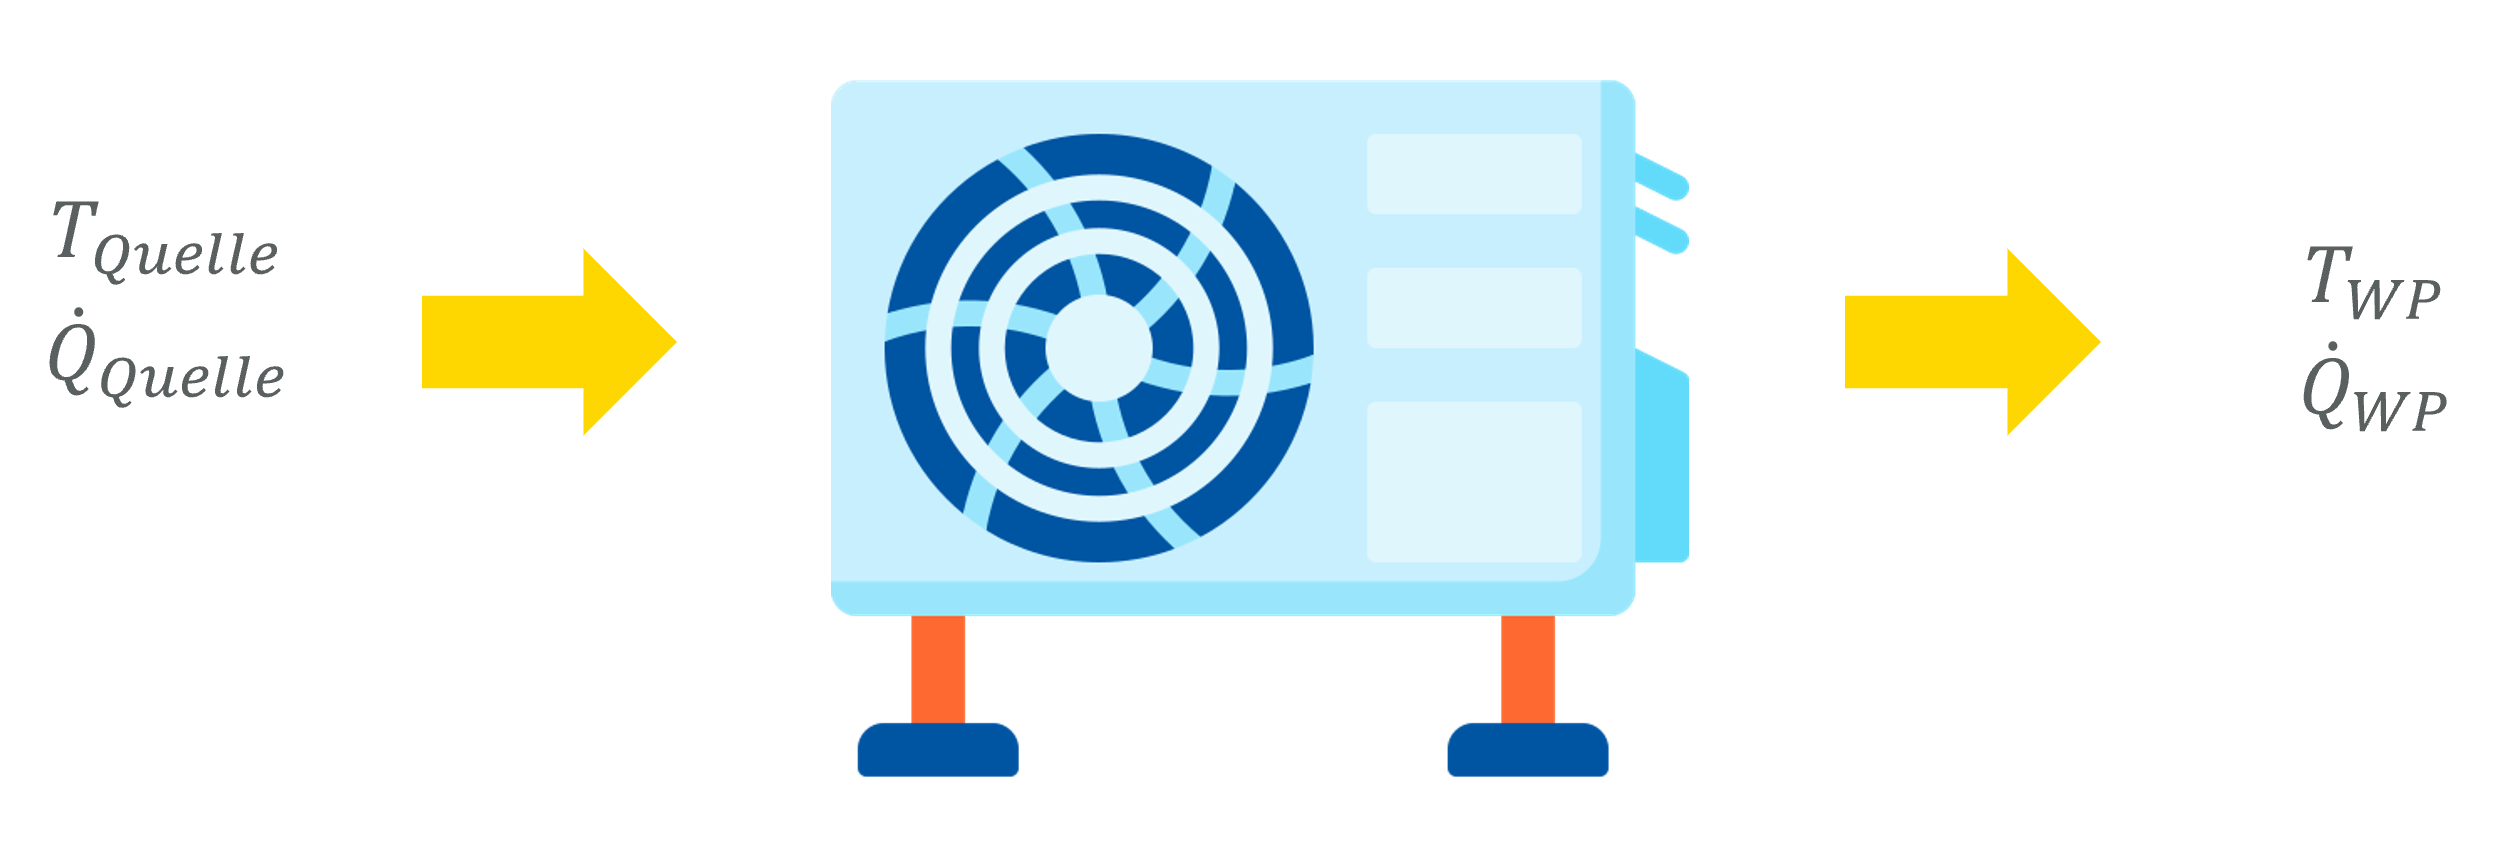

In [19]:
from IPython.display import Image
Image("D:\MASTERARBEIT\Simulation\Bilder\WP.png", width=500, height=300)

#### Technisch

In [20]:
# Die Wärmepumpe wird dazugeschaltet, wenn das Temperaturniveau auf Abnehmerseite nicht eingehalten werden kann. Es soll zunächst nur ein
# einfaches Modell betrachtet werden -> konstanter COP, maximaler Temperaturhub, lineare Kosten pro Leistung

#Eingang
model.WP_T_Verdampfer = Var(model.n, domain=NonNegativeReals) #[°C] # Eingangstemperatur aus der Quelle
model.WP_Q_Verdampfer = Var(model.n, domain=NonNegativeReals) #[kW_th]
model.WP_m_Kondensator = Var(model.n, domain=NonNegativeReals) #[kg/s] # Massenstrom aus der Wärmepumpe

#Komponente
#model.WP_COP = Param(initialize=4.25) #Entnommen aus Kalkulation Cuxhaven
#model.WP_COP_carnot = Param(initialize=3)
model.WP_P_elektrisch = Var(model.n, domain=NonNegativeReals) #[kW_el]

#Ausgang
model.WP_Q_Kondensator = Var(model.n, domain=NonNegativeReals) #[kW_th]
model.WP_T_Kondensator = Var(model.n, domain=NonNegativeReals) #[°C]

#### Ökonomisch

In [21]:
# Investitionskosten
model.WP_capex = Var(model.n, domain=NonNegativeReals)

# Laufkosten
model.WP_opex = Var(model.n, domain=NonNegativeReals)

### Leitung

#### Technisch

In [22]:
"""Die Leitung hat zwar einen Vor- und Rücklauf, aber die Kosten werden über die Trassenlänge definiert. Hier werden Werte für die Verluste und Kosten
Frank Görner verwendet.
Für "die grüne Wiese", also unbebaute Fläche, kann ein Preis von 550 €/m angenommen werden.
Der Verlust über die gesamte Länge ist definiert über die Wärmeleitung in den Erdboden mit ca. 𝜆 = 0,0897 W/mK """

#Eingang
model.L_T_Ein = Var(model.n, domain=NonNegativeReals) #[°C] # Temperatur, welche in die Leitung eingeht
model.L_H_Ein = Var(model.n, domain=NonNegativeReals) #[kW] # Enthalpie, welche in die Leitung reinströmt
model.m_L_Ein = Var(model.n, domain=NonNegativeReals) #[kg/s] # Massenstrom, der ins Rohr fließt

#Komponente
model.lambda_D = 0.0221 #[W/mK] # Leitung durchs Rohr
model.lambda_Bo = 1.6 #[W/mK] # Leitung in den Boden
model.r_M = 0.110 #[m] # Mantel
model.r_R = 0.0418 #[m] # Rohr
model.h_ü = 1 #[m] # Überdeckung
model.L_U = 2*math.pi / (1/model.lambda_D * math.log(model.r_M / model.r_R) + 1 / model.lambda_Bo * math.log(4 * (model.h_ü + model.r_M) / 2 * model.r_M))

model.L_Q_Verlust = Var(model.n, domain=NonNegativeReals) #[W] # Verlustleistung über Rohrlänge 

model.L_T = Var(model.n, domain=NonNegativeReals) #[°C] # Temperatur an einer bestimmten Stelle im Rohr
model.T_Boden = 10 #[°C] # Mittlere Erdreichtemperatur


#Ausgang
model.L_T_Aus = Var(model.n, domain=NonNegativeReals) #[°C] # Ausgangstemperatur aus der Leitung
model.L_H_Aus = Var(model.n, domain=NonNegativeReals) #[kW] # Ausgangsenthalpie aus der Leitung

#Constraints



#### Ökonomisch

In [23]:
# Investition
model.k_Leitung = 630  #[€/m] # Haupttrasse DN200 mit d=630mm
model.L_capex = Var(model.n, domain=NonNegativeReals)

# Constraints


### Abnehmer

Um eine Plausibilität in der Kalkulation zu erzeugen, ist der Wärmebedarf eine freie Variable. Um diese besser greifen zu können,
wird die Anzahl der Hausanschlüsse verwendet. Ein Einfamilienhaus hat zunächst einen übers Jahr homogenen Wärmebedarf von 20,000 kWh/a.
In einer späteren Version werden saisonale Phänomene mitberücksichtigt.
Die Kosten pro Killowattstunde, die ein Kunde zahlen muss um die Kosten zu decken, ist letztlich die Größe von Interesse.

#### Technisch

In [24]:
#Eingang
model.S_Q_Ein = Var(model.n, domain=NonNegativeReals) #[kW]
model.S_W_gesamt = Var(model.n, initialize=500E3, domain=NonNegativeReals) # [kWh/a]
model.S_T_Ein = Var(model.n, initialize=60, domain=NonNegativeReals) #[°C] # Temperatur, die am Abnehmer ankommt


#### Ökonomisch

In [25]:
# Investitionskosten
model.A_capex = Var(model.n, domain=NonNegativeReals)

# Einnahmen
model.A_Kosten = Var(model.n, domain=NonNegativeReals) #[ct/kWh] # Kundenpreis, Einnahme des Unternehmens
#model.A_wärmemischpreis = 60 #[ct/kWh] Einnahmen

# Constraints

#model.C_A_Kosten = Constraint( expr = model.A_Kosten[i, l, z] == model.K_Quelle +  model.WP_capex[i, l, z] + model.WP_opex[i, l, z] + model.L_capex[i, l, z] + model.A_capex[i, l, z])

# Der Wärmemischpreis sind die Kosten über die gesamte Energie
# Da die Verbraucher gleich sind, ist die Anzahl der Häuser auch irrelevant erstmal

# model.C_A_Preis = Constraint( expr = model.A_wärmemischpreis == model.A_Kosten *100 / model.S_Q_Ein ) #[ct/kWh] # Nichtlinear

## Lösung: Constraints in die Schleife mit einbeziehen, wenn es um die indizierten Parameter geht

In [26]:
results = []
results_WP = []
results_VB = []
results_costs = []

# Verschachtelte Schleifen über die Parameterbereiche
for i in range(1, len(temperature)):  # Indizierter Parameter für T_Quelle
    for l in range(1, len(length)):  # Indizierter Parameter für L_l
        for z in range(1, len(number)):  # Indizierter Parameter für S_n

            model.T_Quelle[i,l,z] = temperature[i]
            model.L_l[i,l,z] = length[l]
            model.S_n[i,l,z] = number[z] 

            #%run Bilanzen_ohne_T.ipynb

            ### Quelle

            # Energiebilanz Wärmestrom aus der Quelle
            #model.Con_Quelle_Aus = Constraint( expr = model.Quelle_H_Aus[i,l,z] <= model.Quelle_H_max)
            model.Con_Abnehmer = Constraint( expr = model.WP_Q_Kondensator[i,l,z] >= model.S_n[i,l,z] * model.Siedlung_Q_Haus)
            'Die Randbedingungen wurden so gewählt, dass es keinen Lösungsraum gab'
            

            ### Wärmepumpe

            # Bilanzen in die Wärmepumpe hinein
            model.Con_WP_Eingang_T = Constraint( expr = model.WP_T_Verdampfer[i,l,z] == model.T_Quelle[i,l,z])
            model.Con_WP_Ein_H = Constraint ( expr = model.WP_Q_Verdampfer[i,l,z] <= model.Quelle_H_Aus[i,l,z])


            # Energiebilanz in der Wärmepumpe
            model.Con_WP_COP = Constraint( expr = model.WP_Q_Kondensator[i,l,z] == model.WP_COP * model.WP_P_elektrisch[i,l,z])
            model.Con_WP_EB = Constraint( expr = model.WP_Q_Kondensator[i,l,z] == model.WP_P_elektrisch[i,l,z] + model.WP_Q_Verdampfer[i,l,z])
            'Q_Verdampfer hat keine EB'
            model.C_WP_T_balance = Constraint( expr = (model.WP_T_Kondensator[i,l,z] + 273.15) == (model.WP_T_Verdampfer[i,l,z] + 273.15) + model.WP_Q_Kondensator[i,l,z]*1000/model.WP_COP_carnot)

            model.Con_WP_P_max = Constraint ( expr = model.WP_P_elektrisch[i,l,z] <= model.WP_P_max)
            model.Con_WP_Q_Kondensator_max = Constraint( expr = model.WP_Q_Kondensator[i,l,z] <= model.WP_Q_Kondensator_max)
                
            
            # Kalkulation Wärmepumpe
            model.C_WP_capex = Constraint( expr = model.WP_capex[i,l,z] == model.WP_P_elektrisch[i,l,z] * model.WP_invest) # Variabel von der Lesitung            
            model.C_WP_opex = Constraint( expr = model.WP_opex[i,l,z] == model.WP_P_elektrisch[i,l,z] * 8760 * model.c_electricity * 0.01)            
                                   
            
            # Energiebilanz Wärmepumpe-Leitung
            #model.Con_Leitung_EB = Constraint ( expr = model.L_H_Ein[i,l,z] == model.WP_Q_Kondensator[i,l,z])
            
            #model.Con_Leitung_T_Ein = Constraint( expr = model.WP_T_Kondensator[i,l,z] == model.L_T_Ein[i,l,z])
            
            ### Leitung
            
            # Energiebilanz der Leitungsverluste
            #model.Con_Leitung_Verlust = Constraint( expr = model.L_H_Aus[i,l,z] == model.L_H_Ein[i,l,z] - model.L_Q_Verlust[i,l,z]*0.001)
            #model.Con_Leitung_Verlust = Constraint( expr = model.L_H_Aus[i,l,z] == model.L_H_Ein[i,l,z] * (1-0.15))
            #model.Con_Leitung_Q_Verlust = Constraint( expr = model.L_Q_Verlust[i,l,z] == model.L_U * model.L_l[i,l,z] * (0.5 * (model.L_T_Ein[i,l,z] + model.L_T_Aus[i,l,z]) - model.T_Boden))
            #model.Con_Leitung_T_Verlust = Constraint( expr = model.L_T_Aus[i,l,z] == model.L_T_Ein[i,l,z] * (1-0.15))
            'Aktuelle Annahme: Leitungsverlust von 15% -> m*c bleibt konstant, daher verlieren wir 15% der Temperatur'
            # Kalkulation Leitung            
            #model.Con_Leitung_Capex = Constraint( expr = model.L_capex[i,l,z] == model.k_Leitung * model.L_l[i,l,z])
            
            ### Siedlung
            
            # Energiebilanz
            #model.Con_Siedlung_EB = Constraint( expr = model.S_Q_Ein[i,l,z] == model.L_H_Aus[i,l,z])
            #model.Con_Siedlung_T = Constraint( expr = model.S_T_Ein[i,l,z] == model.L_T_Aus[i,l,z])                                
            #model.C_S_T = Constraint( expr = model.S_T_Ein[i,l,z] >= model.S_T_Soll)
                       
            #model.C_S_Q = Constraint( expr = model.S_Q_Ein[i,l,z] >= model.S_Q_min / 8760)
            #model.Con_Siedlung_H = Constraint( expr = model.S_Q_Ein[i,l,z] >= model.S_n[i,l,z] * model.S_Q_Haus)
            #model.C_VB_W = Constraint( expr = model.S_W_gesamt[i,l,z] == model.S_Q_Ein[i,l,z] * 8760)
            
            # Kalkulation Siedlung
            #model.C_A_capex = Constraint( expr = model.A_capex[i,l,z] == model.A_k * model.S_n[i,l,z])

            #
            
            #Objective Function
            model.objective = Objective(
                expr = model.WP_capex[i,l,z] + model.WP_opex[i,l,z], 
                sense=minimize
            )
            
            # Lösen des Optimierungsproblems mit Gurobi
            results_solver = SolverFactory('gurobi').solve(model)
            
            # Überprüfen, ob die Optimierung erfolgreich war
            if results_solver.solver.termination_condition == TerminationCondition.optimal:
                zielfunktionswert = value(model.objective)  # Wert der Zielfunktion nach Lösung
                
                # Speichere die Ergebnisse (T, l, n, Zielfunktionswert)
                results.append([value(model.T_Quelle[i,l,z]), value(model.L_l[i,l,z]), value(model.S_n[i,l,z]), zielfunktionswert])
                #results_WP.append([value(model.WP_T_Kondensator[i,l,z]), value(model.WP_T_Verdampfer[i,l,z]), value(model.WP_P_elektrisch[i,l,z])])
                #results_VB.append([value(model.S_W_gesamt[i,l,z]), value(model.S_T_Ein[i,l,z])])
                #results_costs.append([value(model.WP_capex[i,l,z]), value(model.WP_opex[i,l,z]), value(model.L_capex[i,l,z]), value(model.A_capex[i,l,z])])
            else:
                print(f"Optimierung für T={i}, l={l}, n={z} nicht erfolgreich")

# Konvertiere die Ergebnisse in ein numpy-Array für einfache Verarbeitung
results = np.array(results)
#results_WP = np.array(results_WP)
#results_VB = np.array(results_VB)
results_costs = np.array(results_costs)

# Extrahiere die Variablen für die Visualisierung
T_vals = results[:, 0]
l_vals = results[:, 1]
n_vals = results[:, 2]
zielfunktionswerte = results[:, 3]

(type=<class 'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown
with a new Component (type=<class
'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
indicative of a modelling error. To avoid this warning, use
block.del_component() and block.add_component().
(type=<class 'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown
with a new Component (type=<class
'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
indicative of a modelling error. To avoid this warning, use
block.del_component() and block.add_component().
(type=<class 'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown
with a new Component (type=<class
'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
indicative of a modelling error. To avoid this warning, use
block.del_component() and block.add_component().
'pyomo.core.base.constraint.ScalarConstraint'>) on block unknown with a new
Component (type=<class
'pyomo.core.base.co

In [27]:
print(results)
print()
print("Wärmepumpe")
print(results_WP)
print()
print("Verbraucher")
print(results_VB)
print(results_costs)

[[1.00000e+01 5.00000e+01 1.00000e+00 1.71308e+04]
 [1.00000e+01 5.00000e+01 2.00000e+00 3.42616e+04]
 [1.00000e+01 5.00000e+01 3.00000e+00 5.13924e+04]
 [1.00000e+01 5.00000e+01 4.00000e+00 6.85232e+04]
 [1.00000e+01 5.00000e+01 5.00000e+00 8.56540e+04]
 [1.00000e+01 1.00000e+02 1.00000e+00 1.71308e+04]
 [1.00000e+01 1.00000e+02 2.00000e+00 3.42616e+04]
 [1.00000e+01 1.00000e+02 3.00000e+00 5.13924e+04]
 [1.00000e+01 1.00000e+02 4.00000e+00 6.85232e+04]
 [1.00000e+01 1.00000e+02 5.00000e+00 8.56540e+04]
 [1.00000e+01 1.50000e+02 1.00000e+00 1.71308e+04]
 [1.00000e+01 1.50000e+02 2.00000e+00 3.42616e+04]
 [1.00000e+01 1.50000e+02 3.00000e+00 5.13924e+04]
 [1.00000e+01 1.50000e+02 4.00000e+00 6.85232e+04]
 [1.00000e+01 1.50000e+02 5.00000e+00 8.56540e+04]
 [2.00000e+01 5.00000e+01 1.00000e+00 1.71308e+04]
 [2.00000e+01 5.00000e+01 2.00000e+00 3.42616e+04]
 [2.00000e+01 5.00000e+01 3.00000e+00 5.13924e+04]
 [2.00000e+01 5.00000e+01 4.00000e+00 6.85232e+04]
 [2.00000e+01 5.00000e+01 5.000

### Plot der Ergebnisse

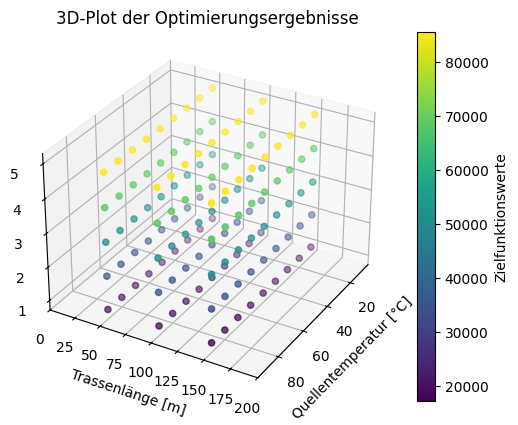

In [28]:
from mpl_toolkits.mplot3d import Axes3D

# Erstelle eine Figur und einen 3D-Achsen
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Erstelle den 3D-Plot
sc = ax.scatter(T_vals, l_vals, n_vals, c=zielfunktionswerte, cmap='viridis')


# Füge eine Farbskala hinzu
plt.colorbar(sc, label='Zielfunktionswerte')

# Setze die Achsenbeschriftungen
ax.set_xlabel('Quellentemperatur [°C]')
ax.set_ylabel('Trassenlänge [m]')
ax.set_zlabel('Anzahl der Hausanschlüsse')
plt.ylim(0,200)
ax.view_init(elev=30, azim=30)

# Füge einen Titel hinzu
ax.set_title('3D-Plot der Optimierungsergebnisse')

# Zeige den Plot an
plt.show()

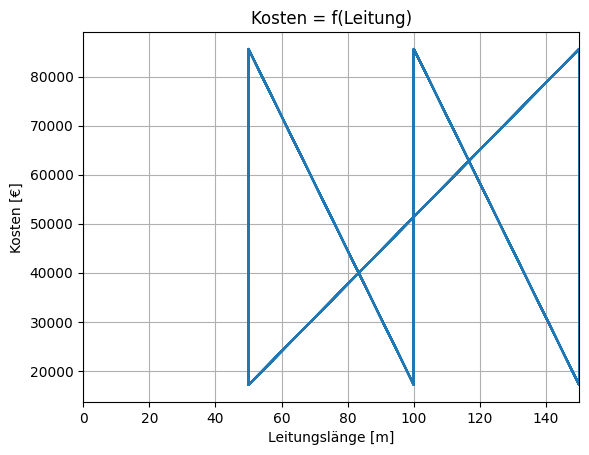

In [29]:
fig, ax = plt.subplots()
ax.plot(l_vals, zielfunktionswerte)

ax.set(xlabel='Leitungslänge [m]', ylabel='Kosten [€]',
       title='Kosten = f(Leitung)')
plt.xlim(0,150)
ax.grid()

plt.show()

In [ ]:
for i in model.I:
        print(value(model.S_T_Ein[i,l,z]))

60
60
60
60
60
60
60
60
60
60
